# OCCLUSION

This tutorial focuses on showing how to use Captum's implementation for object detection occlusion

In [1]:
import torch

import cv2
import torch
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadImages
from utils.general import check_img_size,  non_max_suppression,  scale_coords
from utils.plots import plot_one_box
from utils.torch_utils import select_device



import captum
from captum.attr import  Occlusion 
from captum.attr import visualization as viz


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 


### 1.1 Load the model and dataset

In [2]:
device = select_device('cpu')


yolo = attempt_load('best_weight/best_multi-view_learn.pt',device)

stride = int(yolo.stride.max())  # model stride
imgsz = check_img_size(512, s=stride)  # check img_size

# changex here according to your img to analyse
source = "images/uav_view.jpg"
dataset = LoadImages(source, img_size=imgsz, stride=stride)

#print(f"imgsz={imgsz}")

#print(yolo)
half= False

yolo.eval()

Fusing layers... 


/home/pamasi/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): Conv(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (3): Conv(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (4): Conv(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (5): Conv(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (6): Concat()
    (7): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (8): MP(
      (m): MaxPool2d(kernel_size=2, stride=2, padding=0,

Show all class in the dataset


In [3]:
names = yolo.module.names if hasattr(yolo, 'module') else yolo.names
#no usage 255  or 0 to avoid not visible bbox display  
colors = [[random.randint(30, 200) for _ in range(3)] for _ in names]

print(f'names of class detection\n{names}')

names of class detection
{'person': 0, 'bike': 1, 'car': 2, 'other vehicle': 3}


How to retrieve one data from dataset with opencv2

path=/home/pamasi/Documents/ThermalCamera/tir_ai/Mlcv_YOLO_TIR/yolov7/images/uav_view.jpg
img=(1, 416, 512)	im0s=(512, 640, 1)
path=/home/pamasi/Documents/ThermalCamera/tir_ai/Mlcv_YOLO_TIR/yolov7/images/uav_view.jpg
img=torch.Size([1, 1, 416, 512])	im0s=(512, 640, 1)
shape prediction before NMS=torch.Size([1, 13104, 9])
shape prediction after NMS=torch.Size([4, 6])
det=torch.Size([4, 6])
p=/home/pamasi/Documents/ThermalCamera/tir_ai/Mlcv_YOLO_TIR/yolov7/images/uav_view.jpg	s=	im0=(512, 640, 1)	frame=0
det after boxe rescale to fit img=torch.Size([4, 4])

detection
Class=2.0	det=3
Class=3.0	det=1

names of detected classes
3 cars, 1 other vehicle, 
xyxy shape=4	conf=0.5508497953414917	cls=2.0
labels are
car 0.55
xyxy shape=4	conf=0.7784320116043091	cls=3.0
labels are
other vehicle 0.78
xyxy shape=4	conf=0.8797823190689087	cls=2.0
labels are
car 0.88
xyxy shape=4	conf=0.8954194784164429	cls=2.0
labels are
car 0.90


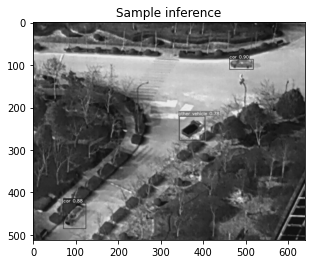

label with max conf score=2, which is car


In [4]:
# img the padded img necessary to yolo-grid
# img0 the input img for yolo backbone 

max_label_idx = None 
for path, img, im0s, _ in dataset:
    print(f"path={path}\nimg={img.shape}\tim0s={im0s.shape}")
    
    # load img into device
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    
    # normalize img to used in nn 
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        # add a new dimension for batch size
        img = img.unsqueeze(0)
    print(f"path={path}\nimg={img.shape}\tim0s={im0s.shape}")
        
    # inference
    
    with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
        pred = yolo(img, augment=False)[0]
    print(f"shape prediction before NMS={pred.shape}")
    
    pred = non_max_suppression(pred)
    
    print(f"shape prediction after NMS={pred[0].shape}")
    
    # PREDITICION IS MAED OF [BOUNDING BOX COORDINATE, CONFIDENCE SCORE, CLASS NUMBER]
    # Process detections
    for det in pred:  # detections per image
        print(f"det={det.shape}")
        
        # s string containg the label name
        p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
        
        print(f"p={p}\ts={s}\tim0={im0.shape}\tframe={frame}")
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            print(f"det after boxe rescale to fit img={det[:, :4].shape}")
            
            print(f"\ndetection")
            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                print(f"Class={c}\tdet={n}")
                #FIXME try to access as integet but stored as name, maybe is it necessary to change structure
                s += f"{n} {list(names.keys())[list(names.values()).index(int(c))]}{'s' * (n > 1)}, "  # add to string
                
            print(f"\nnames of detected classes\n{s}")

            
            # take the label with hte most confidence score
            conf_max = 0.0 
            for *xyxy, conf, cls in reversed(det):
                print(f"xyxy shape={len(xyxy)}\tconf={conf}\tcls={cls}")
                # retrieve the detected label with the corresponding results 
                # for sake of simplicity we use cls
                
                label = f'{list(names.keys())[list(names.values()).index(int(cls))]} {conf:.2f}'
                print(f"labels are\n{label}")
                
                if conf_max< conf:
                    max_label_idx = int(cls)
                
                # Add bbox to image
                plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)
            
                        # Stream results
            # view_img
                        
            # in order to see img in proper color to plt
            backtorgb = cv2.cvtColor(im0,cv2.COLOR_GRAY2RGB)
            
            plt.imshow(backtorgb)
            plt.title('Sample inference')
            plt.show()

    print(f"label with max conf score={max_label_idx}, which is {list(names.keys())[list(names.values()).index(int(max_label_idx))]}")
    
 


### Apply Occlusion

Define the model that we'll be used in the occlusion class

In [5]:
def wrapped_yolo(input, additional_forward_args):
    #print(f"inp={input.shape}")
    expected_cls = additional_forward_args[0]
    expected_bbox = additional_forward_args[1]
    thresh_bbox = additional_forward_args[2]
    best_idx = additional_forward_args[-1]
    
    pred_yolo  = yolo(input, augment=False)[0]
    # print(f"pred_yolo={pred_yolo.shape}")
    nms_pred = non_max_suppression(pred_yolo)[0]
    # print(f"predicted classs={nms_pred.shape}")
    
    
    # cls = nms_pred[best_idx,5]
    cls = expected_cls
    
    if nms_pred.shape[0]==0:
        tmp = torch.zeros(6)
        tmp[0:4] = torch.tensor([2000.0]*4)
        tmp[5] =cls
        # set conf to 0
        tmp[4]=0.0001
        
    else:
        
        bbox = nms_pred[best_idx,:4]
        # print(f"predicted classs={cls}")
        # check predict class for debug
        # print(f"predicted classs={cls}")

        
        # check that best class with the same bbox is always at that position
        # max is used 'cuz values are either  the original position (pos) or -1 
        idx_still_best_class= max([   pos if ith_tensor[5]==cls  and torch.norm(expected_bbox-ith_tensor[:4], p=float('inf'), dim=0)==0 else -1  for pos,ith_tensor in  enumerate(nms_pred) ])

        idx_best_class_under_thresh= max([   pos if ith_tensor[5]==cls  and torch.norm(expected_bbox-ith_tensor[:4], p=float('inf'), dim=0)<thresh_bbox else -1  for pos,ith_tensor in  enumerate(nms_pred) ])
        
        # print("idx of all of same class",[  pos if i[5]==cls else -1 for pos,i in  enumerate(nms_pred) ])
        # used for the debug the order in yolo is not always the same or not even one
        # assert best_class_under_thresh!=-1, f"no class({best_class_under_thresh}) that match the same bbox or nearest, actual bbox={nms_pred[best_class_under_thresh,:4]} expected bbox={bbox}"
        
        # assert still_best_class!=0, f"actual best conf score not always in fst position({still_best_class}), actual bbox={nms_pred[still_best_class,:4]} expected bbox={bbox}"
        
        
        # handle particular case of impossible detection
        if idx_still_best_class<0:

            #print(f"actual best conf score not always in fst position({still_best_class}), actual bbox={nms_pred[still_best_class,:4]} expected bbox={bbox}")
            if idx_best_class_under_thresh<0:
                
                #print( best_class_under_thresh!=-1, f"no class({best_class_under_thresh}) that match the same bbox or nearest, actual bbox={nms_pred[best_class_under_thresh,:4]} expected bbox={bbox}")
                
                tmp = torch.zeros(6)
                tmp[5]=cls
                # set conf to 0
                tmp[4]=0.0001
                
                #fictious bbox that increase bad attribution in most case
                # tmp[0:4]=expected_bbox
                tmp[0:4]=bbox
            else:
                tmp = nms_pred[idx_best_class_under_thresh]
        else:
            tmp = nms_pred[best_idx]
        
        
        # assert were made to under captum occlusion on the fly
        # assert cls==expected_cls, f"error the best index has changed feature class{cls} occlusion not possible the actual best class is at index={still_best_class}"
        # check bouding box not to far away to expected one
        # using using L-infinity norm for "far fighettino" and write less
        # if not met set to zero the confidence to give a negative contribution in the heat map
        # print(f"expected bbox shape={expected_bbox.shape}")
        # print(f"bbox shape={bbox.shape}")
        
        # already integrated  above
        #if torch.norm(expected_bbox-bbox, p=float('inf'), dim=0)>thresh_bbox:
        #    nms_pred[4]=0
    
    
    # adde bacth dim to please captum method
    pred_tensor =  torch.unsqueeze(tmp, 0)
    
    # checl nms shape
    # print(f"nms pred shape={tmp.shape}")
    # print(f"nms pred {pred_tensor}")
    
    # use only the first value of the prediction
    return  pred_tensor

### Retrieve one img from dataloader

In [6]:
for path, img_input, im0s, _ in dataset:

    print(f"path={path}\ninput img={img_input.shape}\tim0s={im0s.shape}")

    # load img into device
    img = torch.from_numpy(img_input).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32

    # normalize img to used in nn 
    # img size=[416,512] -> 212992
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        # add a new dimension for batch size
        img = img.unsqueeze(0)
    print(f"path={path}\nimg={img.shape}\tim0s={im0s.shape}")
        
    # inference

    # prediction format [ cls, conf, bbox_x, bbox_y, bbox_x_h, bbox_y_w]
    with torch.no_grad(): 
        pred = yolo(img,augment=False)[0]
    print(pred.shape)


    # prediction format [list of  tensor([ bbox_x, bbox_y, bbox_x_h, bbox_y_w,  conf, cls] .... [ bbox_x, bbox_y, bbox_x_h, bbox_y_w,  conf, cls]] ) ]
    pred = non_max_suppression(pred)[0]

    # print(f"aft nms={pred.shape}")

    # return the index of the max confidence score

    #print(pred)
    # the idx 4 correspond to confidence score from the tensor list
    best_idx = torch.argmax(pred[:, 4]).item()
    # print(best_idx )


    # return the class of the max confidence score
    best_conf = pred[best_idx,4]
    best_cls = pred[best_idx,5]
    #uncomment to rescale to tensor img to yolo before resize
    #bbox = scale_coords(img.shape[2:], pred[:, :4], im0s.shape).round()
    bbox =pred[best_idx,:4]


    # return the class of the max confidence score
    print(f"bestconf={best_conf}\tbest_cls={best_cls}")
    # print(f"pred[conf,5]={pred[8,:5]}")
    predicted_label = list(names.keys())[list(names.values()).index(2)]

    print('Predicted:', predicted_label, '(', best_conf, ')')


    input_img_viz = np.transpose(img_input, (1,2,0) )

    # add bbox to img   
    plot_one_box(bbox, input_img_viz, label=predicted_label, color=colors[int(best_cls)], line_thickness=1)

path=/home/pamasi/Documents/ThermalCamera/tir_ai/Mlcv_YOLO_TIR/yolov7/images/uav_view.jpg
input img=(1, 416, 512)	im0s=(512, 640, 1)
path=/home/pamasi/Documents/ThermalCamera/tir_ai/Mlcv_YOLO_TIR/yolov7/images/uav_view.jpg
img=torch.Size([1, 1, 416, 512])	im0s=(512, 640, 1)
torch.Size([1, 13104, 9])
bestconf=0.8954194784164429	best_cls=2.0
Predicted: car ( tensor(0.89542) )


### Apply occlusion

In [7]:
occlusion = Occlusion(wrapped_yolo)

# usefull reminder:
# change stride and sliding windows shape
# baseline -> 255 (for white)
# baseline -> random value using a tensor of same dimension of the sliding windows shapes
# target =4 to compute confidence score variation wrt occlusion
attributions_occ = occlusion.attribute( img,
                                       
                                       target=4,
                                        strides=(1, 8,8),
                                        sliding_window_shapes=(1,16, 16),
                                        show_progress=True,
                                        additional_forward_args=[best_cls, bbox, 80.0, best_idx],
                                        baselines=torch.randint(0,255, size=(1,416,512)))


# select only change of confidence score

Occlusion attribution: 100%|██████████| 3214/3214 [03:58<00:00, 13.47it/s]


### Visualize result

attr occ shape=torch.Size([1, 416, 512])
attr occ shape=(416, 512, 1)
attr occ shape=(416, 512, 1)


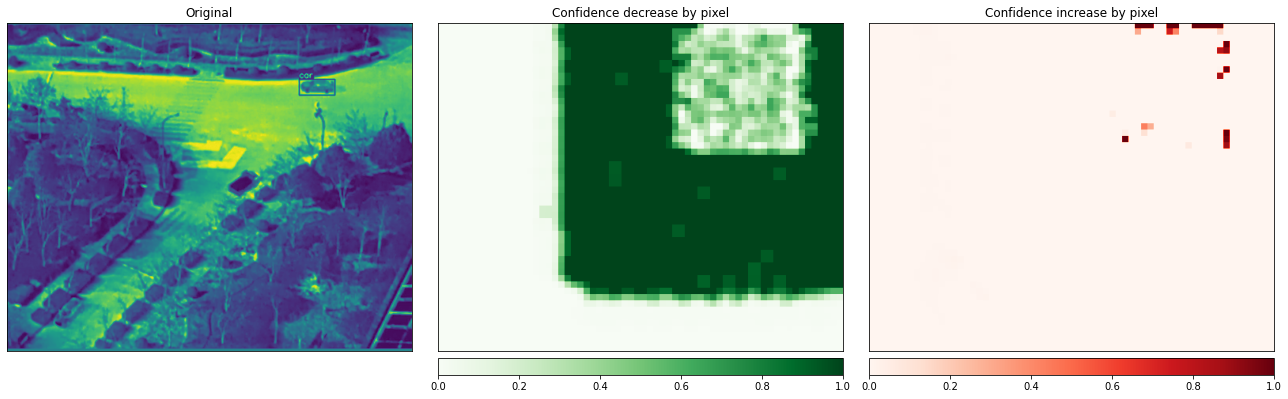

In [8]:
# print(f"attr occ shape={attributions_occ.shape}")
  
# transform to  shape  in the form (H, W, C)
print(f"attr occ shape={attributions_occ[0,:].shape}") 
    
attr_viz =  np.transpose(attributions_occ[0,:].cpu().detach().numpy(), (1,2,0) )  
print(f"attr occ shape={attr_viz.shape}")
print(f"attr occ shape={input_img_viz.shape}")
fig, axis= viz.visualize_image_attr_multiple( attr_viz,
                                    input_img_viz ,
                                    ["original_image", "heat_map", "heat_map"],
                                    ["all", "positive", "negative"],
                                    titles=["Original", "Confidence decrease by pixel", "Confidence increase by pixel"],
                                    show_colorbar=True,
                                    outlier_perc = 10,
                                    fig_size=(18, 6),
                    
                                    )